# INM702 Coursework Task 2
### Aaron Mir (Student Number: 160001207)

The second task is about classifying handwritten digits. We will use the MNIST dataset for training and testing. The point of this task is to develop a multi-layer neural network for classification using mostly Numpy:


    • Implement sigmoid and relu layers (with forward and backward pass) hidden layers

    • Implement a softmax output classification layer 
    
    • Implement a fully parameterizable neural network (number and types of layers, number of units)

    • Implement an optimizer(e.g. SGD or Adam)and a stopping criterion of your choosing

    • Train your Neural Network using backpropagation

    • Keep track of your statistics i.e. different means/variance

Evaluate different neural network architectures and compare your different results. e.g. fully relu vs fully sigmoid, number of layers etc.

You can also compare withthe results presented in http://yann.lecun.com/exdb/mnist/

In [96]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torchvision import datasets, transforms
np.set_printoptions(linewidth=200)
np.random.seed(1)

In [109]:
def MNIST_load():
    train_set = datasets.MNIST(root='./data', train=True, download=True, transform=None)
    test_set = datasets.MNIST(root='./data', train=False, download=True, transform=None)
    #train_set =torch.utils.data.DataLoader(train,train_set =  batch_size=len(train), shuffle=True)
    #test_set = torch.utils.data.DataLoader(test, batch_size=len(test), shuffle=True)
    X_train = train_set.data.numpy()                    # Transforms tensors to np array
    y_train = train_set.targets.numpy()
    X_test = test_set.data.numpy()
    y_test = test_set.targets.numpy()
    return train_set, test_set, X_train, y_train, X_test, y_test

In [110]:
train_set, test_set, X_train_raw, y_train_raw, X_test_raw, y_test_raw = MNIST_load()

In [111]:
def MNIST_preprocessing(MNIST_train, MNIST_train_label, MNIST_test, MNIST_test_label): # normalise, center, standardise, flatten and shuffle
    print('Data type of MNIST_train: %s' % MNIST_train.dtype)
    #print('Min: %.3f, Max: %.3f' % (MNIST_train.min(), MNIST_train.max()))
    MNIST_train = MNIST_train.astype('float32')
    MNIST_test = MNIST_test.astype('float32')
    print('New data type of MNIST_train: %s' % MNIST_train.dtype)
    MNIST_train /= 255.0
    MNIST_test /= 255.0
    print('New Min: %.3f, New Max: %.3f' % (MNIST_train.min(), MNIST_train.max()))
    print('Data has been normalised')
    
    mean_train = MNIST_train.mean()
    mean_test = MNIST_train.mean()
    print('Mean of training set: %.3f' % mean_train)
    #print('Min: %.3f, Max: %.3f' % (MNIST_train.min(), MNIST_train.max()))
    MNIST_train = MNIST_train - mean_train
    MNIST_test = MNIST_test - mean_test
    mean_train = MNIST_train.mean()
    mean_test = MNIST_test.mean()
    print('New mean of training set: %.3f' % mean_train)
    #print('New Min: %.3f, New Max: %.3f' % (MNIST_train.min(), MNIST_train.max()))
    print('Data has been centered')

    mean_train, std_train = MNIST_train.mean(), MNIST_train.std()
    mean_test, std_test = MNIST_test.mean(), MNIST_test.std()
    print('Standard deviation of training set: %.3f' % std_train)
    MNIST_train = (MNIST_train - mean_train) / std_train
    MNIST_test = (MNIST_test - mean_test) / std_test
    # confirm it had the desired effect
    mean_train, std_train = MNIST_train.mean(), MNIST_train.std()
    mean_test, std_test = MNIST_test.mean(), MNIST_test.std()
    print('New mean of training set: %.3f, New standard deviation of training set: %.3f' % (mean_train, std_train))
    print('Data has been standardised')

    MNIST_train = MNIST_train.reshape(MNIST_train.shape[0], -1)
    MNIST_test = MNIST_test.reshape(MNIST_test.shape[0], -1)
    MNIST_train_keys = np.array(range(MNIST_train.shape[0]))
    MNIST_test_keys = np.array(range(MNIST_test.shape[0]))
    np.random.shuffle(MNIST_train_keys)
    np.random.shuffle(MNIST_test_keys)
    MNIST_train = MNIST_train[MNIST_train_keys]
    MNIST_train_label = MNIST_train_label[MNIST_train_keys]
    MNIST_test = MNIST_test[MNIST_test_keys]
    MNIST_test_label = MNIST_test_label[MNIST_test_keys]
    print("Data has been flattened and shuffled")
    return MNIST_train, MNIST_train_label, MNIST_test, MNIST_test_label

In [112]:
X_train, y_train, X_test, y_test = MNIST_preprocessing(X_train_raw, y_train_raw, X_test_raw, y_test_raw)

Data type of MNIST_train: uint8
New data type of MNIST_train: float32
New Min: 0.000, New Max: 1.000
Data has been normalised
Mean of training set: 0.131
New mean of training set: -0.000
Data has been centered
Standard deviation of training set: 0.308
New mean of training set: 0.000, New standard deviation of training set: 1.000
Data has been standardised
Data has been flattened and shuffled


In [119]:
print(X_train.shape, X_test.shape) # 6000 per classification for X_train and 1000 for X_test - balanced - 785 features for each image

(60000, 784) (10000, 784)


In [105]:
y_train[0]

3

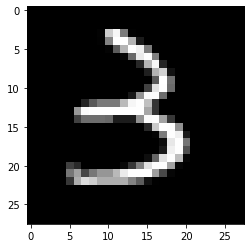

In [118]:
plt.imshow((X_train[0].reshape(28, 28)), cmap='gray');

In [41]:
weights = 0.01 * np.random.randn(4, 3)

In [42]:
np.round(np.var(weights))

0.0

In [126]:
X = np.load("other_data/X.npy")         # Testing FC_layer class with data found online
y = np.load("other_data/y.npy")

In [129]:
class FC_Layer:     #Relu or Sigmoid activation
    '''A class to represent a fully-connected layer with random initialisation of weights.'''
    def __init__(self, num_inputs, num_neurons):
        self.weights = 0.01 * np.random.randn(num_inputs, num_neurons)                                      # random initialisation of weights with biases set to 0 MAYBE CHANGE 0.01
        print('Weights initialised at mean: %.3f, variance: %.3f, and dimensions: %.0d, %.0d' \
            % (np.mean(self.weights), np.var(self.weights), num_inputs, num_neurons))
        self.biases = np.zeros((1, num_neurons))                                                            

    def forward_pass(self, inputs):
        self.output = np.dot(inputs, self.weights) + self.biases                                            # output of this layer will be inputs*w+b

In [130]:
class ReLU:
   def forward_pass(self, input):
      self.output = np.maximum(0, input) 

In [131]:
fc_layer = FC_Layer(2,3)

Weights initialised at mean: 0.004, variance: 0.000, and dimensions: 2, 3


In [132]:
activation = ReLU()

In [133]:
fc_layer.forward_pass(X)

In [134]:
activation.forward_pass(fc_layer.output)

In [135]:
print(activation.output[:5])              # output has 5 rows and 3 values each as expected

[[0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.65350665e-04]
 [1.93687309e-05 0.00000000e+00 3.82271775e-04]
 [1.77332977e-04 0.00000000e+00 4.86630818e-04]
 [2.18026215e-04 0.00000000e+00 6.82549217e-04]]


In [ ]:
class Softmax:
   def forward_pass(self):
       

In [ ]:
class NeuralNetwork:
    def __init__(self):
        self.layers = [] #will pass through the different layer objects
    
    def add(self, layer): # adds a layer to the network
        self.layers.append(layer)

    def set_params(self, loss=False, optimiser=False, accuracy=False):
        if loss == True:
            self.loss = loss
        
        if optimiser == True:
            self.optimiser = optimiser 

        if accuracy == True:
            self.accuracy = accuracy

In [ ]:
class Input_Layer:
    def forward_pass()

In [ ]:
class Output_Layer: # Softmax
    def __init__(self):

In [ ]:
class Sigmoid:
   def __init__(self):

In [ ]:
class Adam: #or SGD
   def __init__(self):

In [ ]:
class Loss:
    def __init__(self):

In [ ]:
class Accuracy:
    def __init__(self):

In [ ]:
#When we run the NN we want to add layers of different types to it, be able to set the optimiser of choice and evaluate the NN